### Bonus: A Shallow Dive into Deep Learning

To put what I've learned in the Deep Learning Unit into practice, I will attempt to improve upon my Gradient Boosting model from the Machine Learning notebook.

In [1]:
# Import pandas for reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

The initial setup is the same as before.

In [2]:
top_stocks = pd.read_hdf('../data/clean/all_stocks.h5', key='daily')

top_stocks.reset_index(inplace=True)
top_stocks.drop_duplicates(['symbol', 'date'], inplace=True)
top_stocks.set_index('date', inplace=True)

In [8]:
top_stocks.index = pd.to_datetime(top_stocks.index)

In [9]:
top_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 467494 entries, 2008-02-07 to 2020-03-31
Columns: 288 entries, symbol to buy_signal
dtypes: float64(286), int64(1), object(1)
memory usage: 1.0+ GB


In [10]:
import json
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler

X = top_stocks.loc[:'2020-02'][COLUMNS]
y = top_stocks.loc[:'2020-02'][['buy_signal']]

X_backtest = top_stocks.loc['2020-03':][COLUMNS]
y_backtest = top_stocks.loc['2020-03':][['buy_signal']]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [24]:
sm = RandomUnderSampler()
X_train, y_train = sm.fit_resample(X_train, y_train)

To create the neural network model, I will use the Keras library, which is built upon TensorFlow. Keras requires that the result column is in a categorical format, but it provides the function "to_categorical" for this purpose.

The data must first be scaled to improve accuracy. The test data is not scaled independently, but according to the fit of the train data. After testing both the StandardScaler and the MinMaxScaler, the StandardScaler performs better and converges in fewer epochs.

In [25]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_backtest_scaled = scaler.transform(X_backtest)

dump(scaler, open('../models/scaler.pkl', 'wb'))

In [26]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train) 
y_test_cat = to_categorical(y_test)
y_backtest_cat = to_categorical(y_backtest)

To build the neural network, I used a simple sequential model with just one hidden layer containing 100 nodes. I tested many different configurations, but adding layers and nodes did not improve the final test accuracy score. The Rectified Linear Unit or "RELU" activation function performs better than sigmoid activation functions like "tanh". The output layer must have 2 nodes, representing a win or a loss. The "softmax" activation function is also necessary for binary classification, as it converts the outputs to probabilities and ensures that they add up to 1.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()

model.add(Dense(200, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

The model was compiled with the "adam" optimizer. I also chose the "categorical_crossentropy" loss function, a good default for classification. 

In [28]:
from keras.metrics import accuracy
from keras.optimizers import Adam

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

When fitting the model, I used two callbacks provided by Keras. The EarlyStopping callback stops when the validation loss function does not improve after five epochs. The ModelCheckpoint callback saves the model with the best validation accuracy score. I experimented with splitting the training data to create an additional validation set, but setting the test data as the validation set optimizes for test set accuracy.

In [29]:
from keras.callbacks.callbacks import EarlyStopping
from keras.callbacks.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='loss', patience=3)
mc = ModelCheckpoint('../models/buy_signal.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_scaled, y_train_cat, 
          epochs=20, 
          callbacks= [es, mc], 
          batch_size=128,
          validation_data=(X_test_scaled, y_test_cat), 
          shuffle=True)

Train on 226252 samples, validate on 232889 samples
Epoch 1/20
226252/226252 [==============================] - 31s 136us/step - loss: 0.6934 - accuracy: 0.5158 - val_loss: 0.6922 - val_accuracy: 0.5117
Epoch 2/20
226252/226252 [==============================] - 31s 138us/step - loss: 0.6911 - accuracy: 0.5237 - val_loss: 0.6901 - val_accuracy: 0.5289
Epoch 3/20
226252/226252 [==============================] - 30s 134us/step - loss: 0.6902 - accuracy: 0.5299 - val_loss: 0.6906 - val_accuracy: 0.5254
Epoch 4/20
226252/226252 [==============================] - 30s 132us/step - loss: 0.6900 - accuracy: 0.5302 - val_loss: 0.6900 - val_accuracy: 0.5276
Epoch 5/20
226252/226252 [==============================] - 31s 136us/step - loss: 0.6895 - accuracy: 0.5326 - val_loss: 0.6907 - val_accuracy: 0.5243
Epoch 6/20
226252/226252 [==============================] - 32s 141us/step - loss: 0.6890 - accuracy: 0.5353 - val_loss: 0.6897 - val_accuracy: 0.5321
Epoch 7/20
226252/226252 [================

An evaluation of the best model shows a test accuracy of 66.5%. This outperforms any of my previous Machine Learning models, even after hyperparameter tuning. 

In [31]:
from keras.models import load_model

best_model = load_model('../models/buy_signal.h5')
_, train_accuracy = best_model.evaluate(X_train_scaled, y_train_cat)
_, test_accuracy = best_model.evaluate(X_test_scaled, y_test_cat)
_, backtest_accuracy = best_model.evaluate(X_backtest_scaled, y_backtest_cat)
train_accuracy, test_accuracy, backtest_accuracy

1716/1716 [==============================] - 0s 162us/step


(0.5476150512695312, 0.5320689082145691, 0.5268065333366394)

In [32]:
predictions = pd.DataFrame(zip(best_model.predict(X_test_scaled)[:, 1], y_test_cat[:, 1]),
                           columns=['prediction', 'signal'])

In [33]:
predictions['prediction_correct'] = ((predictions.prediction >= 0.5) & (predictions.signal == 1)) | \
                                    ((predictions.prediction < 0.5) & (predictions.signal == 0))

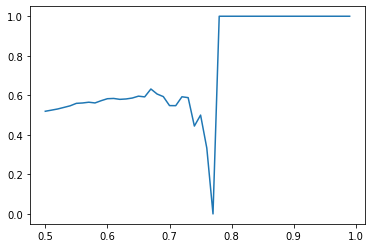

In [34]:
def buy_signal_curve():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.prediction_correct == True)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(correct / total)
    plt.plot(odds, curve)
    
buy_signal_curve()

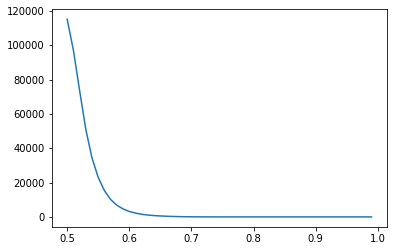

In [35]:
def buy_signal_curve_2():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.signal == 1)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(total)
    plt.plot(odds, curve)
    
buy_signal_curve_2()

I do not believe that the model has much room for improvement. For proof, I trained the model for 100 epochs, and plotted its history. As shown below, the test loss steadily increases after only a few epochs. Similarly, the test accuracy decreases after only a few epochs, then converges. Even at a training accuracy of 75%, the model is overfitting.

The presence of upsets in the match data throw off any attempt at finding general patterns in the features. Increasing the training accuracy can only reduce the model's ability to generalize for the test data. To improve the model at this point, I would need to add new features that can generalize more effectively when encountering upsets in the training data.

. | .
- | - 
![loss](epoch-loss.png) | ![loss](epoch-accuracy.png) 

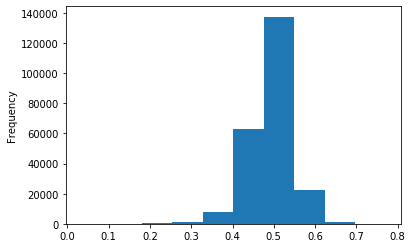

In [36]:
predictions.prediction.plot(kind='hist')

In [37]:
symbols = top_stocks.symbol.unique()

In [39]:
def backtest(forecasts, predictions, buy):
    baseline = 100
    model = 100
    position = 100
    trade = 100
    buy_signal = False
    for date, prediction in zip(forecasts.index, predictions):
        if prediction > buy:
            if buy_signal == False:
                trade = 100
                position = trade
                model -= position
                buy_signal = True
        elif prediction <= buy:
            if buy_signal == True:
                model += position
                buy_signal = False
        if buy_signal == True:
            position += position * forecasts[date]
        baseline += baseline * forecasts[date]
    if buy_signal == True:
        model += position
    return baseline, model

In [48]:
from tqdm.notebook import tqdm

def calculate_profit(symbol, buy):
    X = top_stocks[top_stocks.symbol == symbol].loc['2020-03':][COLUMNS]
    if X.shape[0] == 0:
        return 0, 0
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    forecasts = top_stocks[top_stocks.symbol == symbol].loc['2020-03':].forecast
    
    return backtest(forecasts, predictions, buy)

baselines = []
models = []

num_symbols = 50

for symbol in tqdm(symbols[:num_symbols]):
    baseline, model = calculate_profit(symbol, .55)
    print(symbol, baseline, model)
    if baseline == 0:
        num_symbols -= 1
    baselines.append(baseline)
    models.append(model)

num_symbols * 100, sum(baselines), sum(models)

AAL 56.680801879274355 100
AAPL 80.62314033347202 117.71965389785206
ABBV 82.78272200685849 98.31695158677957
ABT 93.82428516378656 98.25874781068819
AMAT 0 0
AMD 91.99325893307109 104.18734535800793
AMGN 93.21866183006665 122.5757058365004
AMX 68.05556051461095 113.35551190787677
AMZN 97.63299976172563 116.73299613818463
ATVI 94.90014830036947 99.73560559709061
AUY 73.86934781736177 93.58092058869853
BABA 88.89942238922494 98.19587678618917
BAC 0 0
BB 66.1417312117709 100
BBD 54.86211966093762 100
BIDU 80.88101599759689 108.79217321218269
BSM 0 0
BSX 78.88685699749736 108.79124214537136
C 56.975884610227 112.74855036621445
CHK 68.1818212605705 100
CMCSA 76.24646712115866 105.4135994479421
CSCO 93.10178172406906 121.83476161843696
CX 56.50887283882031 100
CY 100.4291862006187 138.41124363455717
DAL 50.61492984831564 85.63844504070221
EBAY 80.03337435865666 91.24584283413755
F 61.11111405455045 114.53869660854258
FB 81.24618413763298 115.72823336431597
FCX 60.09523755028135 100.64516069

(4600, 3414.831465633763, 4830.297476297374)

### Conclusions

- Neural networks are not only useful for image and audio recognition. They can also be a powerful tool for classification.
- Simple models work well for simple data. Complexity should be added only when needed.
- Beware of overfitting. Longer training time does not mean better accuracy on unseen data.
- Utilize callbacks to save the best model, and to stop training early.
- If you're stuck, it might be time to look at the dataset's features.